In [1]:
#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

#advectionGP
from advectionGP.models import AdjointSecondOrderODEModel as Model #Model module builds basic parts of the ODE problem, combines other classes into full model

'''To use other models in the class, such as the Advection Diffusion Reaction model, 
replace "AdjointSecondOrderODEModel" in the line above with "AdjointAdvectionDiffusionReaction" model
and adjust parameters as appropriate'''

from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.test import TestKernels #Unit test model


#Plotting tools
import matplotlib.pyplot as plt
import numpy.random as rd
rd.seed(124)

In [2]:
avg=0.1 # time that an observation is taken for
tlocL = np.linspace(0,9.9,20) # observation start times
X= np.zeros((len(tlocL),2)) # initiate X
# Build sensor locations
X[:,0] = tlocL #lower time
X[:,1] = X[:,0]+avg # upper time


sensors = FixedSensorModel(X,0) # establish sensor model arguments are sensor locations and spatial averaging (not applicable in 1D case so set to 0)


In [3]:
k_0 = -0.5 #Diffusion coefficient
u=1
eta=5
noiseSD = 0.1 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0],[10])# edges of the grid - in units of time
kForward = EQ(np.sqrt(0.6), 1) # generate EQ kernel arguments are lengthscale and variance
res = [200] # grid size for time

In [4]:
m = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kForward,sensormodel=sensors,k_0=k_0,u=u,eta=eta) #initiate PDE model to build concentration

dt,dt2,Nt = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
sourceGT=m.computeSourceFromPhi(z)# Compute ground truth source by approximating GP
#sourceGT = np.ones(m.resolution)  # Example constant source
concTrain=m.computeConcentration(sourceGT) # Compute concentration - runs ODE forward model
yTrain= m.computeObservations(addNoise='TRUE') # Compute observations with noise uses m.sensormodel for observation locations

In [5]:
N_feat =200 #Number of features used to infer the source
kInverse = EQ(np.sqrt(0.6), 1) # Initiate kernel for inverse problem
mInfer = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=sensors,k_0=k_0,u=u,eta=eta) #Initiate new model for inference
mInfer.computeModelRegressors() # Compute regressor matrix 
meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
concInfer=m.computeConcentration(sourceInfer) # Generates estimated concentration from inferred source

Calculating Adjoints...
19/20 
Calculating Phis...
199/200 


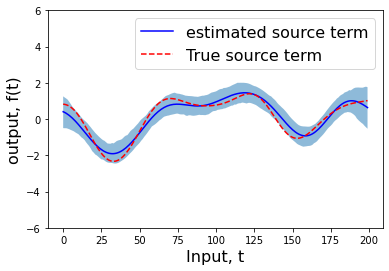

In [6]:
source_samples = []
conc_samples=[]    
for z_samp in np.random.multivariate_normal(meanZ, covZ,200):
    source_samples.append(mInfer.computeSourceFromPhi(z_samp))
    conc_samples.append(mInfer.computeConcentration(mInfer.computeSourceFromPhi(z_samp)))
source_samples=np.array(source_samples)
conc_samples=np.array(conc_samples)

source_lower_ci = np.percentile(source_samples,2.5,0)
source_upper_ci = np.percentile(source_samples,97.5,0)
source_mean = np.percentile(source_samples,50,0)

conc_lower_ci = np.percentile(conc_samples,2.5,0)
conc_upper_ci = np.percentile(conc_samples,97.5,0)
conc_mean = np.percentile(conc_samples,50,0)

xtest=np.arange(Nt)

#plt.figure(figsize=(15, 10))

plt.plot(xtest,sourceInfer,'b-')
plt.plot(xtest,sourceGT,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,source_lower_ci,source_upper_ci,alpha=0.5)
plt.legend(labels=["estimated source term","True source term"],fontsize=16)
#plt.title("Source function ")
plt.xlabel("Input, t",fontsize=16)
plt.ylabel("output, f(t)",fontsize=16)
plt.ylim((-6,6))
#plt.ylim([-5,5])
plt.show()

In [7]:
sourceGTData = np.c_[m.coords,sourceGT]
concGTData = np.c_[m.coords,concTrain]


In [11]:
observations = np.c_[(X[:,1]+X[:,0])/2,concTrain[mInfer.getGridCoord((X[:,1]+X[:,0])/2)]]
observationsNoisy = np.c_[(X[:,1]+X[:,0])/2,concTrain[mInfer.getGridCoord((X[:,1]+X[:,0])/2)]+ np.random.normal(0,noiseSD,20) ] 

In [14]:
#np.savetxt("exactObservationsODEVar1.csv", observations, delimiter=",")
#np.savetxt("noisyObservationsODEVar1.csv", observationsNoisy, delimiter=",")
#np.savetxt("GroundTruthSourceCoordsODEVar1.csv", sourceGTData, delimiter=",")
#np.savetxt("GroundTruthConcCoordsODEVar1.csv",concGTData, delimiter=",")

In [15]:
np.mean((concInfer-concTrain)**2)

0.005565399731753398

In [16]:
import GPy

In [17]:
kGP = GPy.kern.RBF(1, name="rbf")

In [18]:
observationsNoisy[:,0][:,None]

array([[0.05      ],
       [0.57105263],
       [1.09210526],
       [1.61315789],
       [2.13421053],
       [2.65526316],
       [3.17631579],
       [3.69736842],
       [4.21842105],
       [4.73947368],
       [5.26052632],
       [5.78157895],
       [6.30263158],
       [6.82368421],
       [7.34473684],
       [7.86578947],
       [8.38684211],
       [8.90789474],
       [9.42894737],
       [9.95      ]])

In [19]:
mGP = GPy.models.GPRegression(observationsNoisy[:,0][:,None], observationsNoisy[:,1][:,None], kGP)
mGP 

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


In [20]:
mGP.optimize()
mGP

GP_regression.,value,constraints,priors
rbf.variance,0.06443693029332441,+ve,
rbf.lengthscale,0.6652369726177714,+ve,
Gaussian_noise.variance,0.010657701953297134,+ve,


In [21]:
meanGP, Cov = mGP.predict_noiseless(mInfer.coords, full_cov=False)

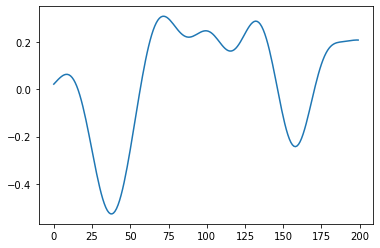

In [22]:
plt.plot(meanGP)

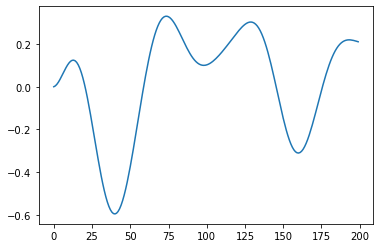

In [23]:
plt.plot(concTrain)

In [24]:
np.mean((meanGP.flatten()-concTrain)**2)

0.005534518219915792

In [25]:
np.mean((concInfer-concTrain)**2)

0.005565399731753398